In [23]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'
import tensorflow as tf
import keras
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib as mpl
from IPython.core.display import display, HTML
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import MinMaxScaler, RobustScaler
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import urllib.request
import requests
import json
import datetime
import os
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

## 데이터 프레임

**train** 20190101 ~ 20200928 <br> 
**test** 20200929 ~ 20201105

EDA와 기본 모델을 만들때 사용 <br>
train + test 합친 프레임(토마토, 포도) = df

In [2]:
raw_path = '/Users/cge/Documents/yeardream/프로젝트/기업프로젝트/products_price_predict/data/raw/'
processed_path = '/Users/cge/Documents/yeardream/프로젝트/기업프로젝트/products_price_predict/data/processed/'

In [3]:
# test 데이터 합치기
arr = os.listdir('/Users/cge/Documents/yeardream/프로젝트/기업프로젝트/data/public_data/test_files')
print(arr)
print()

filename_list = arr
filename_list_2020 = []    
for filename in filename_list :
    if '2020' in filename :
        filename_list_2020.append(filename)
        
path = '/Users/cge/Documents/yeardream/프로젝트/기업프로젝트/data/public_data/test_files/'
df_list = []
for filename in tqdm(filename_list_2020) :
    df = pd.read_csv(path + filename)
    df_list.append(df)
test = pd.concat(df_list, sort=False).reset_index(drop=True)

['test_2020-10-12.csv', 'test_2020-10-06.csv', 'test_2020-10-07.csv', 'test_2020-10-13.csv', 'test_2020-09-30.csv', 'test_2020-10-05.csv', 'test_2020-10-11.csv', 'test_2020-10-10.csv', 'test_2020-10-04.csv', 'test_2020-10-14.csv', 'test_2020-10-28.csv', 'test_2020-10-29.csv', 'test_2020-10-15.csv', 'test_2020-10-01.csv', 'test_2020-10-17.csv', 'test_2020-10-03.csv', 'test_2020-10-02.csv', 'test_2020-10-16.csv', 'test_2020-10-27.csv', 'test_2020-10-26.csv', 'test_2020-10-18.csv', 'test_2020-10-24.csv', 'test_2020-10-30.csv', 'test_2020-10-31.csv', 'test_2020-10-25.csv', 'test_2020-10-19.csv', 'test_2020-10-21.csv', 'test_2020-10-09.csv', 'test_2020-10-08.csv', 'test_2020-10-20.csv', 'test_2020-09-29.csv', 'test_2020-10-22.csv', 'test_2020-10-23.csv', '.ipynb_checkpoints', 'test_2020-11-04.csv', 'test_2020-11-05.csv', 'test_2020-11-02.csv', 'test_2020-11-03.csv', 'test_2020-11-01.csv']



100%|████████████████████████████████████████████████████| 38/38 [00:00<00:00, 886.75it/s]


In [24]:
tomato = pd.read_csv(processed_path+'tomato.csv')
grape = pd.read_csv(processed_path+'grape.csv')
shinemuscat = pd.read_csv(processed_path+'shinemuscat.csv')

train = pd.read_csv(raw_path+'train.csv')

print(train.shape)
print(test.shape)

(1733, 44)
(703, 8)


In [25]:
tomato.date = pd.to_datetime(tomato.date)
tomato = pd.concat([tomato, pd.get_dummies(tomato['요일'])], axis = 1)

grape.date = pd.to_datetime(grape.date)
grape = pd.concat([grape, pd.get_dummies(grape['요일'])], axis = 1)

shinemuscat.date = pd.to_datetime(shinemuscat.date)
shinemuscat = pd.concat([shinemuscat, pd.get_dummies(shinemuscat['요일'])], axis = 1)

In [26]:
print(tomato.shape)
print(grape.shape)
print(shinemuscat.shape)

(1733, 22)
(1733, 22)
(1733, 22)


## train 토마토, 포도(캠벨얼리, 샤인마스캇)만 저장

In [27]:
train = train[['date', '요일','토마토_거래량(kg)', '토마토_가격(원/kg)', '캠벨얼리_거래량(kg)', '캠벨얼리_가격(원/kg)',
       '샤인마스캇_거래량(kg)', '샤인마스캇_가격(원/kg)']]
test = test[['date', '요일','토마토_거래량(kg)', '토마토_가격(원/kg)', '캠벨얼리_거래량(kg)', '캠벨얼리_가격(원/kg)',
       '샤인마스캇_거래량(kg)', '샤인마스캇_가격(원/kg)']]

In [28]:
train.shape

(1733, 8)

In [29]:
df = pd.concat([train, test], axis= 0)
df.shape

(2436, 8)

In [30]:
df.date = pd.to_datetime(df.date)
df = pd.concat([df, pd.get_dummies(df['요일'])], axis = 1)
feature = train.columns[2:]

In [31]:
display(df.head(2))
display(df.tail(2))
print(df.shape)

,date,요일,토마토_거래량(kg),토마토_가격(원/kg),캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg),금요일,목요일,수요일,월요일,일요일,토요일,화요일
0,2016-01-01,금요일,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0
1,2016-01-02,토요일,30950.0,1621.0,880.0,2014.0,0.0,0.0,0,0,0,0,0,1,0


,date,요일,토마토_거래량(kg),토마토_가격(원/kg),캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg),금요일,목요일,수요일,월요일,일요일,토요일,화요일
701,2020-10-30,금요일,177579.0,3643.0,37409.5,3422.0,71023.0,9867.0,1,0,0,0,0,0,0
702,2020-10-31,토요일,249564.0,3115.0,34392.5,2920.0,111721.4,9735.0,0,0,0,0,0,1,0


(2436, 15)


## EDA
### 농산물 품목 별 가격
계절 패턴이 뚜렷하고 품목별로 확연히 다른 분포를 보임 -> 품목별 모델 생성, 시계열 반영 모델 생성

<AxesSubplot:>

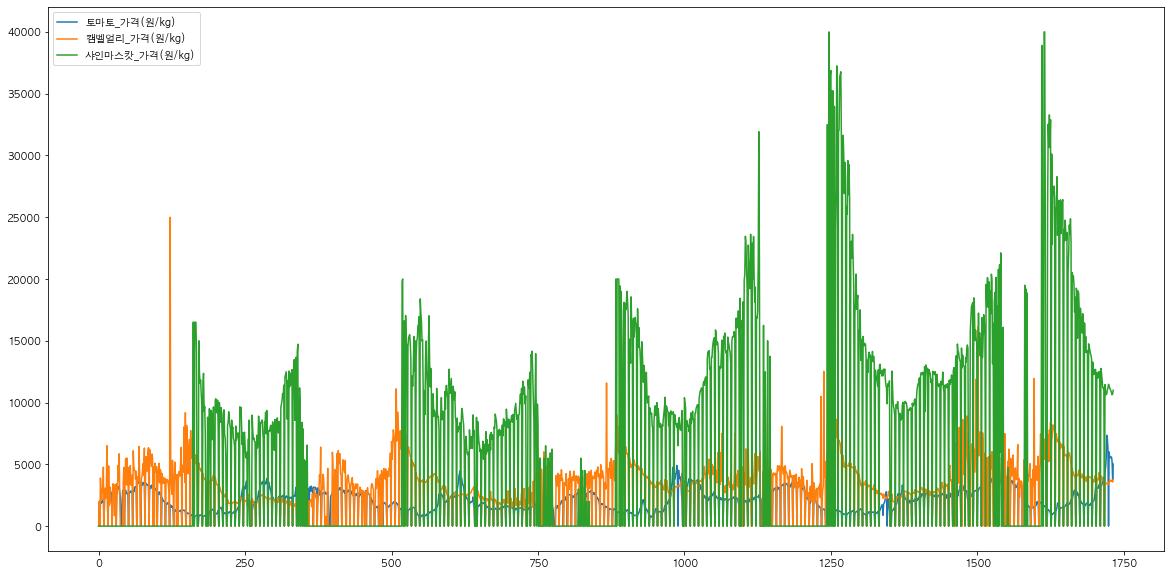

In [43]:
feature_price = []

for i in range(1,4):
    feature_price.append(feature[1::2])

train[feature[1::2]].plot(figsize=(20,10))

### 농산물 가격 분포
특이값이 많이 포함되어 있음 (이상치가 아니라 우리가 예측해야 하는 값)

<AxesSubplot:>

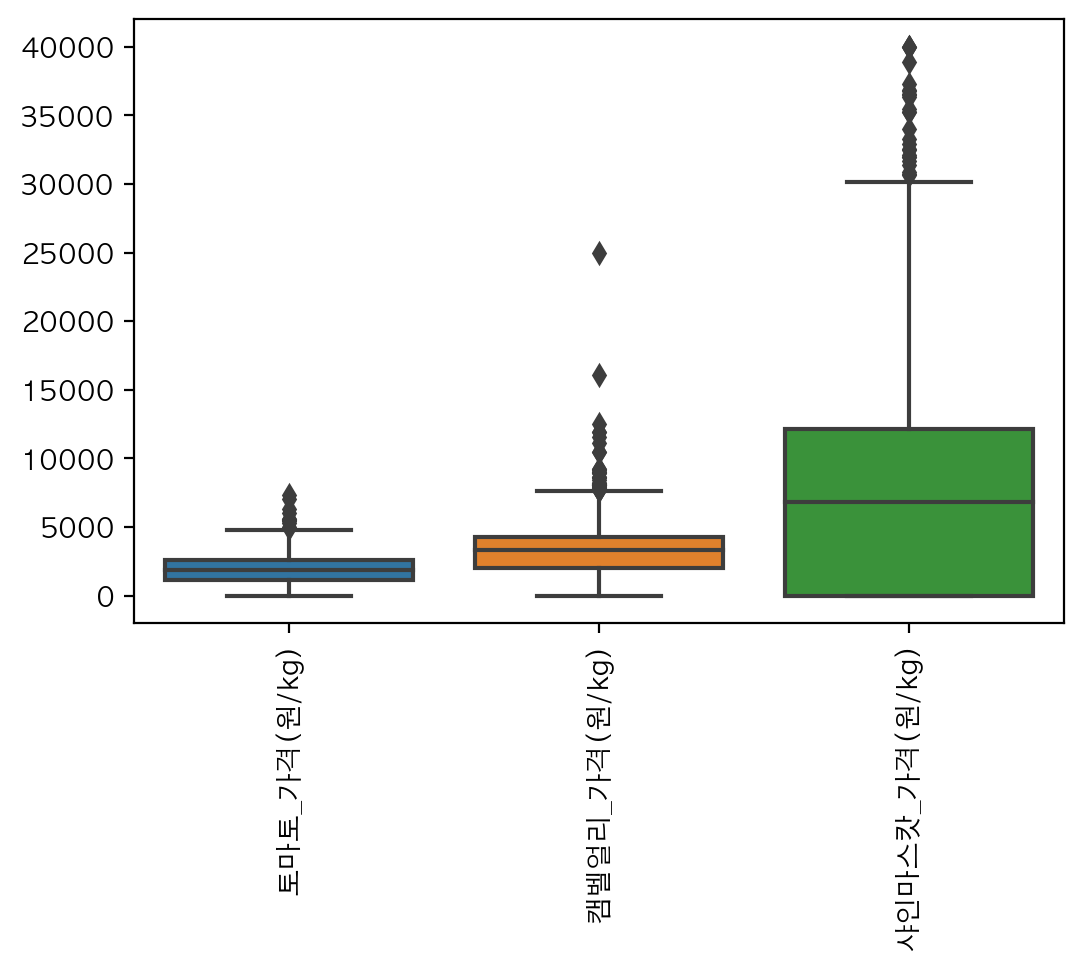

In [44]:
fig = plt.figure(dpi=200)
plt.xticks(rotation = 90)
sns.boxplot(data = train[feature[1::2]])

### 특이값 발생 원인
샤인마스캇 가격 0이 아닐경우만 시각화

> 가격 폭등 2017년부터 매년 50% 이상 매출이 늘고 있다. 농경연은 이달 출하하는 샤인머스캣의 가격이 2㎏에 1만7000 ~ 1만9000원 수준으로 전년 가격 대비 10~20% 가량 내려갈 것으로 전망

<AxesSubplot:>

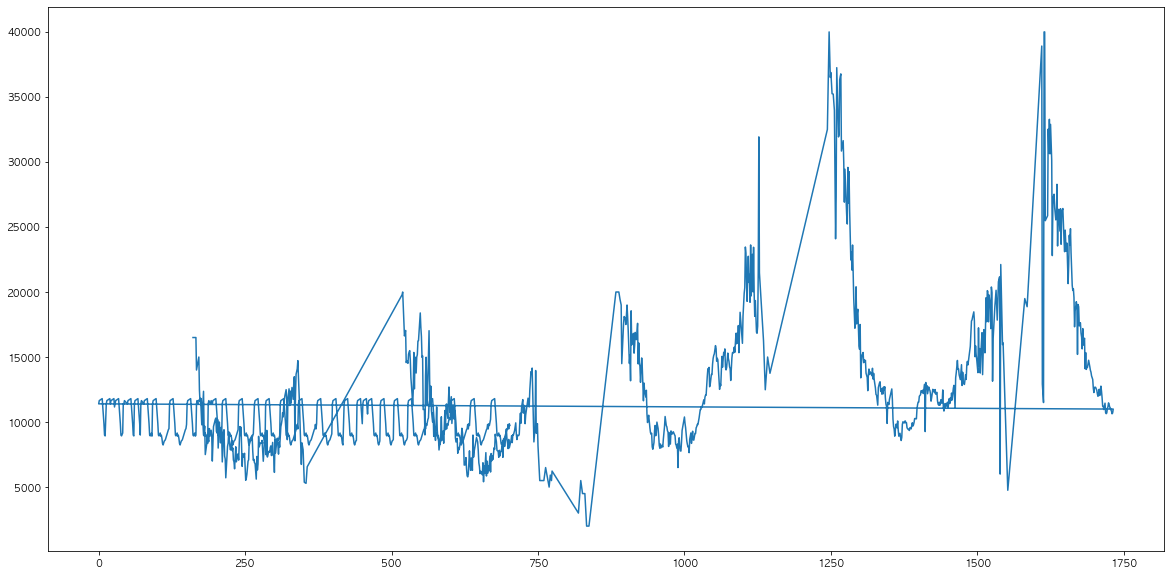

In [34]:
df[df['샤인마스캇_가격(원/kg)'] > 1]['샤인마스캇_가격(원/kg)'].plot(figsize=(20,10))

In [36]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

minmax_scaler = MinMaxScaler()
minmax_scaler = minmax_scaler.fit_transform(shinemuscat.iloc[:,2:])
shinemuscat_scaler = pd.DataFrame(minmax_scaler, columns=shinemuscat.iloc[:,2:].columns)
shinemuscat_scaler

,샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg),소비자물가지수,고급휘발유,보통휘발유,자동차용경유,실내등유,평균기온,최고기온,최저기온,평균운량,일강수량,일교차,금요일,목요일,수요일,월요일,일요일,토요일,화요일
0,0.000000,0.000000,0.0,0.544010,0.360423,0.297384,0.321906,0.244706,0.329670,0.216981,0.00,0.0,0.572816,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.545845,0.357780,0.295554,0.317069,0.284706,0.389011,0.266509,0.00,0.0,0.601942,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.000000,0.000000,0.0,0.543617,0.356312,0.293700,0.314440,0.317647,0.450549,0.280660,0.00,0.0,0.708738,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.000000,0.000000,0.0,0.543328,0.352946,0.290840,0.309031,0.383529,0.404396,0.398585,0.00,0.0,0.364078,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.540366,0.349355,0.286630,0.302899,0.275294,0.270330,0.320755,0.00,0.0,0.228155,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1728,0.740842,0.273500,1.0,0.134062,0.220676,0.201895,0.248276,0.682353,0.679121,0.698113,0.68,0.0,0.354369,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1729,0.794687,0.271100,1.0,0.132699,0.218756,0.200178,0.247210,0.691765,0.731868,0.691038,0.60,0.0,0.485437,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1730,0.819581,0.265900,1.0,0.131230,0.217491,0.198600,0.248048,0.656471,0.712088,0.653302,0.56,0.0,0.519417,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1731,0.025464,0.267475,1.0,0.132410,0.216859,0.197890,0.247248,0.663529,0.707692,0.662736,0.21,0.0,0.490291,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### 모델링
성능을 알아보기 위한 모델 <br>
일주일 후 배추 가격을 예측

In [37]:
shinemuscat_scaler['target'] = shinemuscat_scaler['샤인마스캇_가격(원/kg)'].shift(-8)
shinemuscat_scaler['target']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1728    NaN
1729    NaN
1730    NaN
1731    NaN
1732    NaN
Name: target, Length: 1733, dtype: float64

In [38]:
df_learn = shinemuscat_scaler[shinemuscat_scaler['target'].notnull()]
X = df_learn[['샤인마스캇_거래량(kg)', '샤인마스캇_가격(원/kg)']]
y = df_learn['target']

### 모델의 예측 결과
전반적인 추세는 잘 예측하지만 거래가 발생하지 않는 일요일 전후로 예측 성능이 떨어지는 모습을 보임

큰 폭으로 변동되는 가격은 잘 예측 하지 못함(뾰족뾰족한 부분)

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import seaborn as sns
# import lightgbm as lgb

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, shuffle=True, random_state=42)

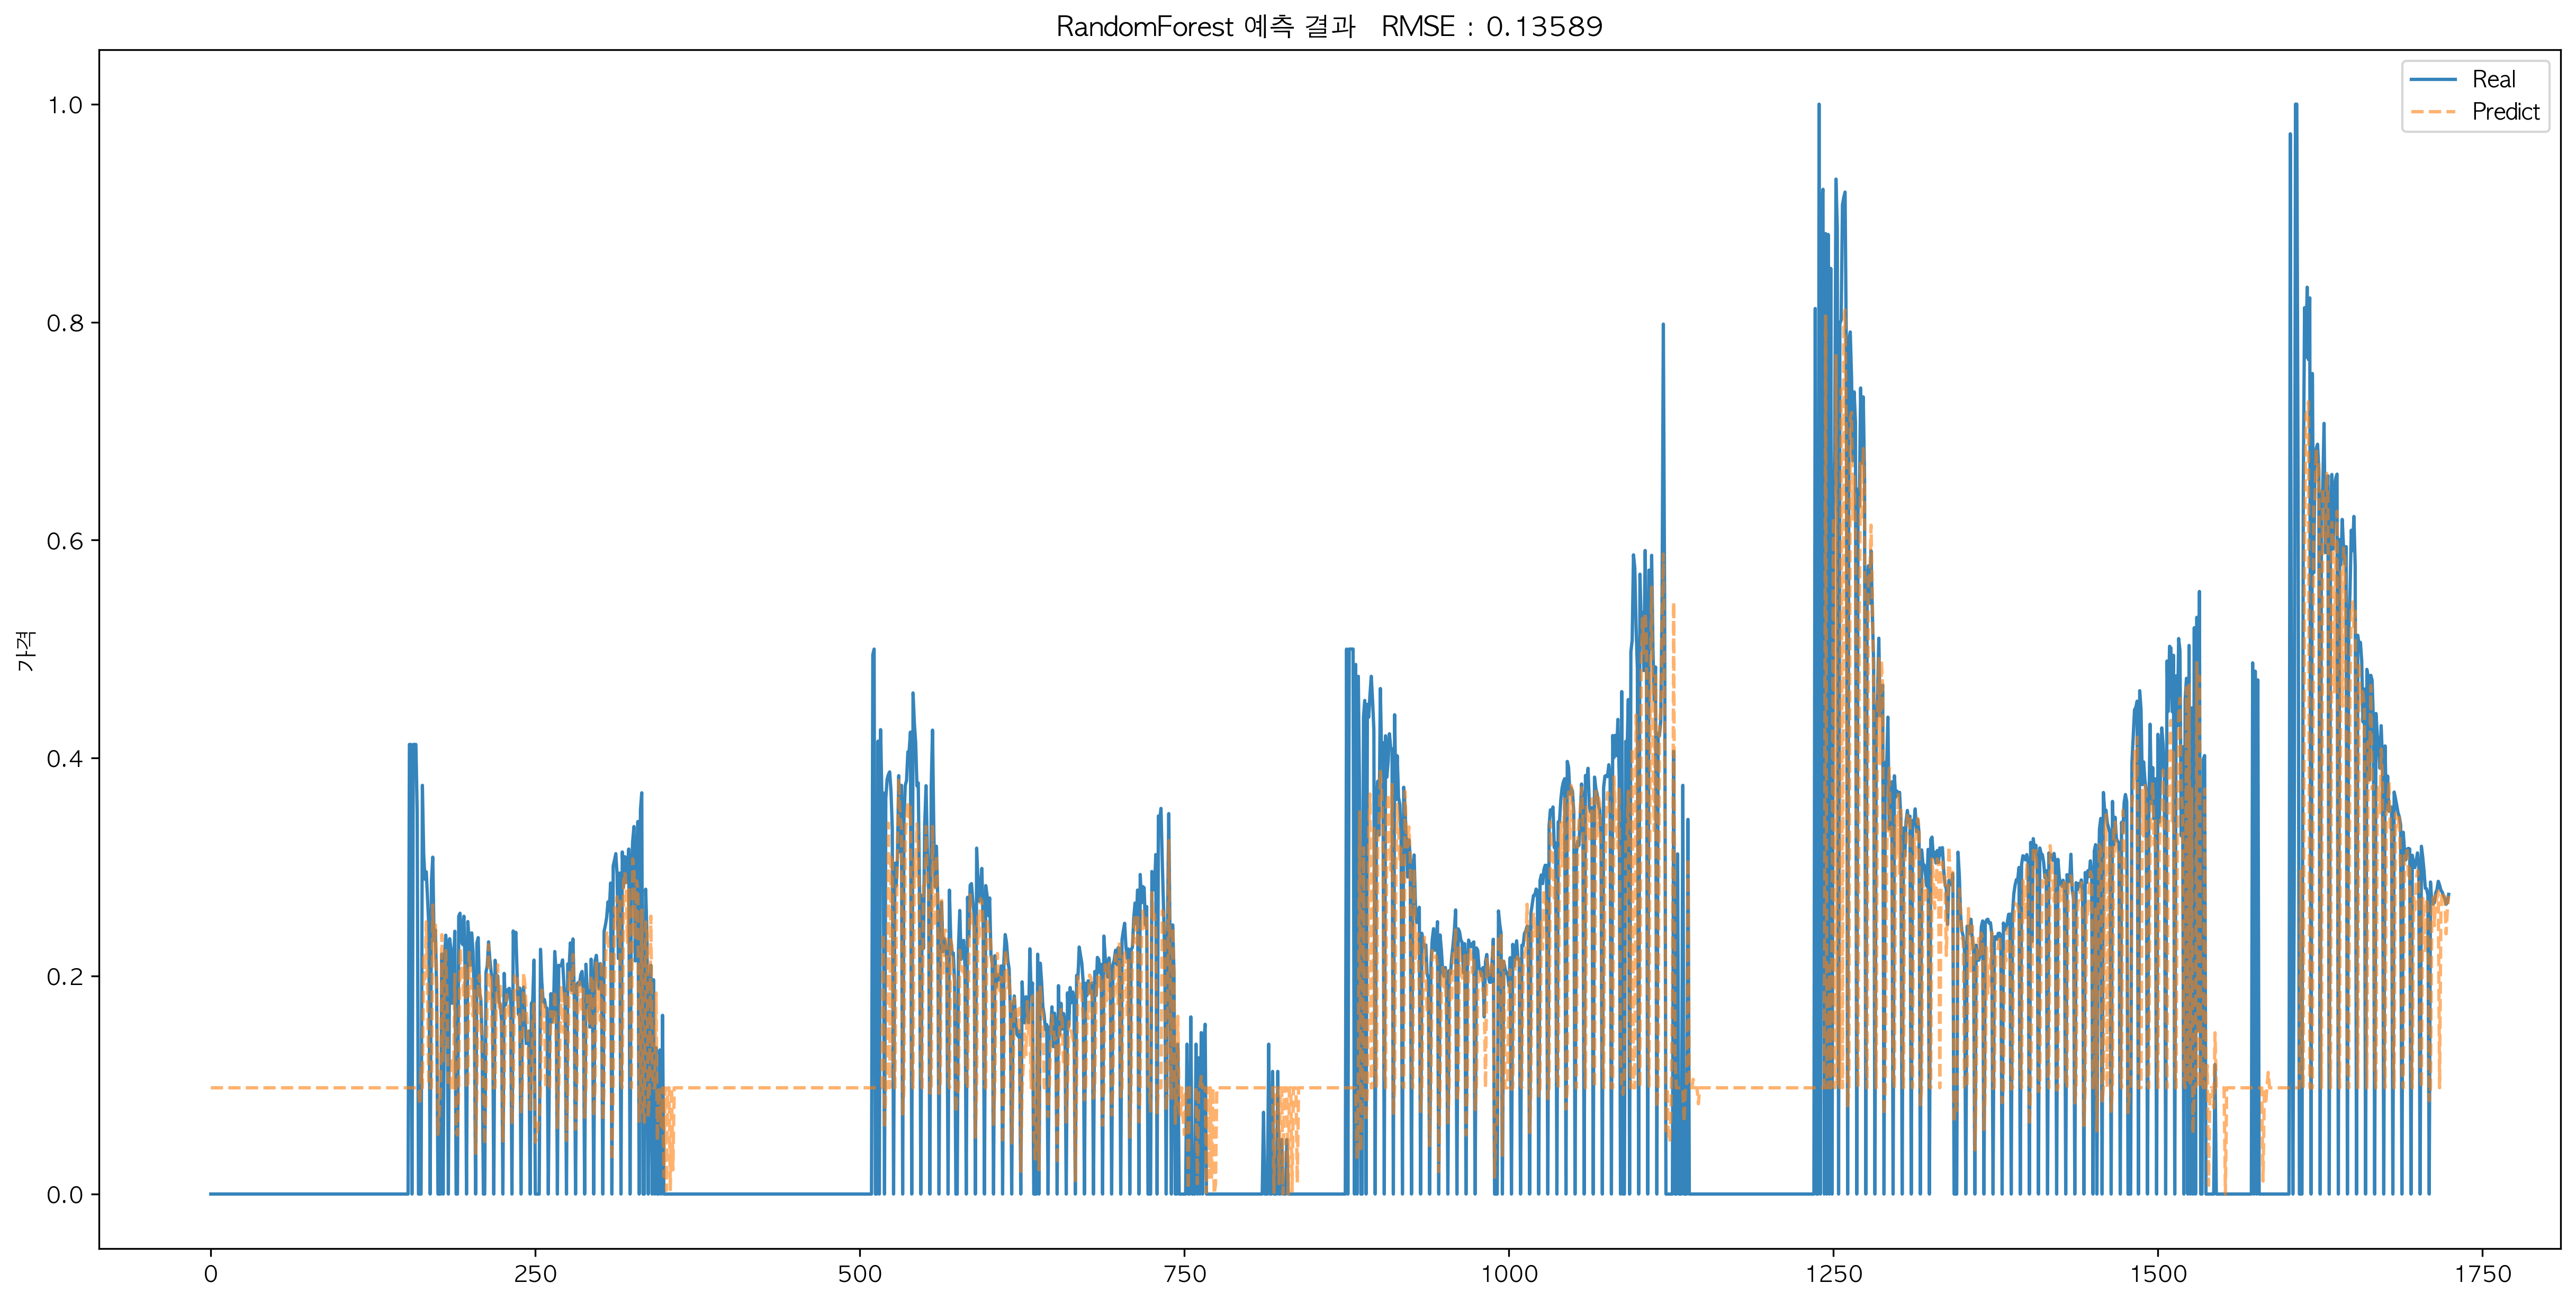

In [40]:
model = RandomForestRegressor()
model.fit(X, y)

# metrics
y_pred = model.predict(X)
RMSE = np.sqrt(mean_squared_error(y, y_pred))


plt.figure(figsize=(20, 10), dpi=300)
plt.title('RandomForest 예측 결과'+   '   RMSE : ' + str(RMSE)[:7])
plt.ylabel('가격')
plt.plot(np.array(y), alpha = 0.9, label = 'Real')
plt.plot(model.predict(X), alpha = 0.6, linestyle = "--", label = 'Predict')
plt.legend()
plt.show()